### 1. Generate images with the original model

In [12]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

'/home/nessessence/mnt_tl_vision16/home/nessessence/uul/dog'

/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

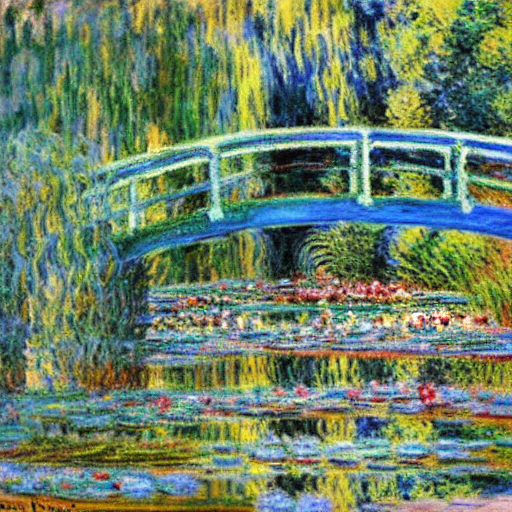

In [2]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)
pipe.safety_checker = None
pipe.requires_safety_checker = False
torch.Generator(device=device).manual_seed(42)
    
prompt = "An artwork by Claude Monet"
image = pipe(prompt).images[0]  
    
display(image)

del pipe
torch.cuda.empty_cache()

### 2. Data preparation for finetuning

In [7]:
import subprocess, os
config_path = "configs/art/erase_monet.yaml"
cuda_num = 0

subprocess.run(
    ["python", "data_preparation.py", config_path],
    env={"CUDA_VISIBLE_DEVICES": str(cuda_num), **dict(**os.environ)}
)

/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

Generating training data for concept 1: claude-monet...
Inferencing: a photo in the style of claude monet


100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


CompletedProcess(args=['python', 'data_preparation.py', 'configs/art/erase_monet.yaml'], returncode=0)

### 3. Finetuning for concept erasure (based on configuration)

In [8]:
import subprocess, os

subprocess.run(
    ["python", "training.py", config_path],
    env={"CUDA_VISIBLE_DEVICES": str(cuda_num), **dict(**os.environ)}
)


/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

Using relation-focal importance sampling, which can make training more efficient
                  and is particularly beneficial in erasing mass concepts with overlapping terms.


Steps: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, loss=31.7, lr=0.0001]

Concept 0: Art piece by claude monet
True
tensor(49.5684, device='cuda:0', grad_fn=<AddBackward0>)
loss: 49.568443298339844
True
tensor(77.8705, device='cuda:0', grad_fn=<AddBackward0>)
loss: 77.87045288085938
True
tensor(78.1854, device='cuda:0', grad_fn=<AddBackward0>)
loss: 78.18538665771484
True
tensor(53.4289, device='cuda:0', grad_fn=<AddBackward0>)
loss: 53.42892074584961
True
tensor(64.1089, device='cuda:0', grad_fn=<AddBackward0>)
loss: 64.10890197753906
True
tensor(62.9366, device='cuda:0', grad_fn=<AddBackward0>)
loss: 62.93663787841797
True
tensor(43.9021, device='cuda:0', grad_fn=<AddBackward0>)
loss: 43.902069091796875
True
tensor(48.5144, device='cuda:0', grad_fn=<AddBackward0>)
loss: 48.514434814453125
True
tensor(38.7412, device='cuda:0', grad_fn=<AddBackward0>)
loss: 38.741188049316406
True
tensor(61.7736, device='cuda:0', grad_fn=<AddBackward0>)
loss: 61.77360153198242
True
tensor(47.4913, device='cuda:0', grad_fn=<AddBackward0>)
loss: 47.491268157958984
True
tensor(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_layer.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_layer.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_layer.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_layer.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_layer.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_layer.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_layer.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_layer.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.lora_layer.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.lora_layer.up.weight, down_bl

============================== Concept 1: claude monet ==============================


100%|██████████| 32/32 [00:03<00:00,  9.73it/s]


CompletedProcess(args=['python', 'training.py', 'configs/art/erase_monet.yaml'], returncode=0)

### 4. Sampling with finetuned model

In [10]:
import subprocess
import os

cmd = [
    "python", "inference.py",
    "--num_images", "2",
    "--prompt", "An artwork by Claude Monet",
    "--model_path", "./saved_model/LoRA_fusion_model",
    "--save_path", "./output"
]

subprocess.run(cmd, env={"CUDA_VISIBLE_DEVICES": str(cuda_num), **os.environ})


/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

unet:
UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_featur

100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


CompletedProcess(args=['python', 'inference.py', '--num_images', '2', '--prompt', 'An artwork by Claude Monet', '--model_path', './saved_model/LoRA_fusion_model', '--save_path', './output'], returncode=0)

In [11]:
import subprocess
import os

cmd = [
    "python", "inference.py",
    "--num_images", "2",
    "--prompt", "An artwork by Van Gogh",
    "--model_path", "./saved_model/LoRA_fusion_model",
    "--save_path", "./output"
]

subprocess.run(cmd, env={"CUDA_VISIBLE_DEVICES": str(cuda_num), **os.environ})


/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nessessence/anaconda3/envs/mace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

unet:
UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_featur

100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


CompletedProcess(args=['python', 'inference.py', '--num_images', '2', '--prompt', 'An artwork by Van Gogh', '--model_path', './saved_model/LoRA_fusion_model', '--save_path', './output'], returncode=0)